In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats



import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EL_jGCaMP7f_CsChrimsontdT')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df = sess_df.iloc[:-1]
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly']  for _, row in sess_df.iterrows()]
sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]


figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/LabMeetings/05_09_2024/EL_jGCaMP7f_CsChrimsontdT')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]

FileNotFoundError: [Errno 2] No such file or directory: '/media/mplitt/SSD_storage/2P_scratch/EL_jGCaMP7f_CsChrimsontdT/sessions.csv'

In [ ]:
sess_df.head()

In [ ]:
for index,row in sess_df.iterrows():
   
    outdir = pathlib.PurePath( basedir  / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    dff = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=False, background_ts='background')[-1,:,:] -1

    heading = np.angle(np.exp(1j*(-1*pp.voltage_recording_aligned[' Heading'].to_numpy()-np.pi)))
    h_mask = np.abs(heading)<2.5


    x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
    # print(offset.shape)


    x_o, y_o = st2p.utilities.pol2cart(np.ones(heading[h_mask].shape), offset[h_mask])
    r, offset_mu = st2p.utilities.cart2pol(x_o.mean(), y_o.mean())

    sess_df.loc[index, 'mean offset'] = offset_mu
    sess_df.loc[index, 'mean vec. len'] = r
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(offset[h_mask])

    
    
    
    


In [3]:
remap_sess_df = sess_df[sess_df['condition']=='remap']
flies = remap_sess_df['fly_id'].unique()
print(flies.shape)

remap_data = {'fly': [],
              'baseline_mu':[],
              'baseline_var':[],
              'baseline_r':[],
              '0deg_mu':[],
              '0deg_var':[],
              '0deg_r': [],
              '180deg_mu':[],
              '180deg_var':[],
              '180deg_r':[],
             }

for fly in flies:
    _df = remap_sess_df['fly_id']==fly
    remap_data['fly'].append(fly)
    
    baseline = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='baseline')]
    remap_data['baseline_mu'].append(baseline['mean offset'].mean())
    remap_data['baseline_var'].append(baseline['offset var.'].mean())
    remap_data['baseline_r'].append(baseline['mean vec. len'].mean())
    
    deg0 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_0deg')]
    remap_data['0deg_mu'].append(deg0['mean offset'].mean())
    remap_data['0deg_var'].append(deg0['offset var.'].mean())
    remap_data['0deg_r'].append(deg0['mean vec. len'].mean())
    
    deg180 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_180deg')]
    remap_data['180deg_mu'].append(deg180['mean offset'].mean())
    remap_data['180deg_var'].append(deg180['offset var.'].mean())
    remap_data['180deg_r'].append(deg180['mean vec. len'].mean())
    
remap_data = pd.DataFrame(remap_data)
remap_data.head()

NameError: name 'sess_df' is not defined

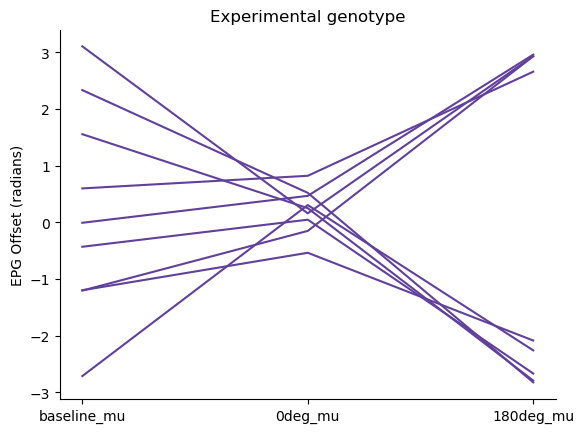

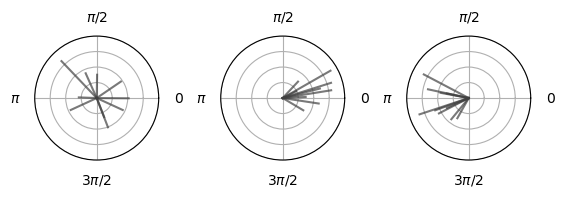

In [6]:
fig, ax= plt.subplots()

_ = ax.plot(remap_data[['baseline_mu','0deg_mu','180deg_mu']].T, color=plt.cm.Purples(.8))
ax.set_ylabel('EPG Offset (radians)')
ax.set_title('Experimental genotype')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(figfolder / "EL_remap.pdf")

fig, ax = plt.subplots(1,3,subplot_kw={'projection': 'polar'})
fig.subplots_adjust(wspace=.5)
for index,row in remap_data.iterrows():
    ax[0].plot(row['baseline_mu']*np.ones([2,]), [0, row['baseline_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[1].plot(row['0deg_mu']*np.ones([2,]), [0, row['0deg_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[2].plot(row['180deg_mu']*np.ones([2,]), [0, row['180deg_r']], color=plt.cm.Greys(.8), alpha=.7)


    
for a in ax:
    a.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([0,.2,.4,.6,.8],['','','','',''])
# ax.plot(

fig.savefig(figfolder / 'EL_remap_polar.pdf')